#**W2D1 Tutorial 1: Creating maps of CMIP6 Earth System Model projections**

> Indented block

> Indented block




**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson (Day Lead), Julius Busecke (Tutorial co-lead), Tom Nicholas (Tutorial co-lead)

**Content reviewers:** Jenna Pearson, Ohad Zivan

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

Today's tutorials demonstrate how to work with data from *Earth System Models* (ESMs) simulations conducted for the recent *Climate Model Intercomparison Project* (CMIP6) 

By the end of today's tutorials you will be able to:

*   Manipulate raw data from multiple CMIP6 models
*   Evaluate the spread of future projections from several CMIP6 models
*   Synthesize climate data from observations and models



#**Setup**



In [1]:
#Imports

!pip install condacolab &> /dev/null        
import condacolab
condacolab.install()

# Install all packages in one call (+ use mamba instead of conda)
# hopefully this improves speed
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf &> /dev/null
# For xesmf install we need to pin "esmf<=8.3.1". More context here: https://github.com/pangeo-data/xESMF/issues/246

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [1]:
import time
tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs

/usr/local/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")
# model_colors = {k:f"C{ki}" for ki, k in enumerate(source_ids)}


In [3]:
# @title Plotting functions

# You may have functions that plot results that aren't 
# particularly interesting. You can add these here to hide them. 

def plotting_z(z):
  """This function multiplies every element in an array by a provided value

  Args:
    z (ndarray): neural activity over time, shape (T, ) where T is number of timesteps
  
   """

  fig, ax = plt.subplots()

  ax.plot(z)
  ax.set(
      xlabel='Time (s)',
      ylabel='Z',
      title='Neural activity over time'
      )



In [4]:
# @title Helper functions

# If any helper functions you want to hide for clarity (that has been seen before
# or is simple/uniformative), add here
# If helper code depends on libraries that aren't used elsewhere,
# import those libaries here, rather than in the main import cell


#**Tutorial 1: Creating maps of CMIP6 Earth System Model projections**



In [5]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

Earth System Models (ESMs) provide physically-based projections of how Earth's climate could change in the coming years, decades, and centuries at both global and local scales. In the following tutorial you will:

- Revisit how to load ESM data from the CMIP6 experiments, and 
- Create maps showing projected future changes in sea surface temperature (SST).

##**Section 1.1: Loading CMIP6 SST data with xarray**

Let's repeat the CMIP6 loading method that we learned in Tutorial 6 on last week's Climate Modelling day. As a reminder we have to specify several *facets* so the code can find the correct datasets.

As a reminder, the *facets* that have to be specified for CMIP6 are:
1. **variable_id**: *tos* = sea surface temperature
2. **source_id**: The CMIP6 model(s) that we want data from 
3. **table_id**: *Omon* (ocean monthly output)
4. **grid_id**: *gn* = data on the model's *native* grid
5. **experiment_id**: *historical*, *ssp126* and *ssp585*. We'll discuss these 3 experiments later today
6. **member_id**: *r1i1p1f1* for now

Now, let's repeat our CMIP6 loading method from the previous tutorial.

*Note: we are going to load datasets from 5 different models (*source_ids*) which you will use throughout today, but in the first two tutorials you will only use one model, **TaiESM1**.*


In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json") # open an intake catalog containing the Pangeo CMIP cloud data

# pick our five example models
# There are many more to test out! Try executing `col.df['source_id'].unique()` to get a list of all available models
source_ids = ['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1']

## **If the following cell crashes, run the cell a second time**

In [8]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id=source_ids,
    variable_id='tos',
    member_id='r1i1p1f1',
    table_id='Omon',
    grid_label='gn',
    experiment_id = ['historical', 'ssp126', 'ssp585'],
    require_all_on = ['source_id'] #make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing, #apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(use_cftime=True), #ensure all datasets use the same time index
    storage_options={'token':'anon'} #anonymous/public authentication to google cloud storage
)
# hopefully we can implement https://github.com/intake/intake-esm/issues/562 before the 
# actual tutorial, so this would be a lot cleaner
cat.esmcat.aggregation_control.groupby_attrs = ['source_id', 'experiment_id']
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


We now have a "datatree" containing the data we searched for. A datatree is a high-level container of xarray data, useful for organizing many related datasets together. You can think of a single `DataTree` object as being like a (nested) dictionary of `xarray.Dataset` objects. Each dataset in the tree is known as a "node" or "group", and we can also have empty nodes. You can explore the nodes of the tree and its contents interactively in a similar way to how you can explore the contents of an `xarray.Dataset`:

In [9]:
dt

DataTree('None', parent=None)
├── DataTree('ACCESS-CM2')
│   ├── DataTree('ssp126')
│   │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, y: 300,
│   │                            x: 360, vertex: 4, bnds: 2)
│   │       Coordinates:
│   │           lat             (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
│   │           lon             (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           lat_verticies   (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
│   │           lon_verticies   (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
│   │           time_bounds     (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
│   │         * y               (y) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
│   │         * x               (x) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
│   │           lon_bounds      (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│   │           lat_bounds      (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Dimensions without coordinates: vertex, bnds
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 201, 300, 360), meta=np.ndarray>
│   │       Attributes: (12/63)
│   │           Conventions:                      CF-1.7 CMIP-6.2
│   │           activity_id:                      ScenarioMIP
│   │           branch_method:                    standard
│   │           branch_time_in_child:             60265.0
│   │           branch_time_in_parent:            60265.0
│   │           cmor_version:                     3.4.0
│   │           ...                               ...
│   │           intake_esm_attrs:variable_id:     tos
│   │           intake_esm_attrs:grid_label:      gn
│   │           intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCC...
│   │           intake_esm_attrs:version:         20191108
│   │           intake_esm_attrs:_data_format_:   zarr
│   │           intake_esm_dataset_key:           ACCESS-CM2/ssp126
│   ├── DataTree('historical')
│   │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 300,
│   │                            x: 360, vertex: 4, bnds: 2)
│   │       Coordinates:
│   │           lat             (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
│   │           lon             (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           lat_verticies   (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
│   │           lon_verticies   (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
│   │           time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
│   │         * y               (y) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
│   │         * x               (x) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
│   │           lon_bounds      (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│   │           lat_bounds      (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Dimensions without coordinates: vertex, bnds
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 202, 300, 360), meta=np.ndarray>
│   │       Attributes: (12/63

# 

###**Coding Exercise 1.1: Mapping projected changes in SST**

Let's look at some projected future changes using the CMIP6 data you just loaded!

In this coding exercise your goals are to: 
1. Create a map of the projected sea surface temperature in July 2100 under a high-emissions scenario (we'll discuss scenarios in the next mini-lecture) using data from a single model (called *TaiESM1*).
2. Create a map showing how this sea surface temperature projection is different from the current (July 2023) sea surface temperature in the same model
3. Plot a similar map that shows how *January* 2100 is different from *January* 2023

To get you started, we have provided code to load the required data set into a variable called *sst_ssp585*, and we have plotted the current (July 2023) sea surface temperature from this data set.

Once you have created the plot, consider the following question:

* What do you think is interesting about these maps of change?
* In what ways are the July and January maps similar or dissimilar, and can you think of any physical explanations for these (dis)similarities?

Many of the changes seen in the maps are a result of a changing climate under this high-emissions scenarios. But, keep in mind that these are differences between two months that are almost 80 years apart, so some of the changes are due to weather/synoptic differences between these particular months.

In [10]:
%matplotlib inline

#################################################
## TODO for students: details of what they should do ##
# Fill out function and remove
raise NotImplementedError("Student exercise: Create a map of the projected sea surface temperature in July 2100 under a high-emissions scenario (ssp585) using data from the TaiESM1 model. Also create maps showing the difference between July 2100 and 2023, and another showing the difference for January of the same years.")
#################################################

# select just a single model and experiment
sst_ssp585 = dt['TaiESM1']['ssp585'].ds.tos

fig, ([ax_present, ax_future], [ax_diff_july, ax_diff_jan]) = plt.subplots(
    ncols=2, nrows=2,
    figsize=[12,6],
    subplot_kw={'projection':ccrs.Robinson()}
)

# plot a timestep for 2023
sst_present = sst_ssp585.sel(time='2023-07').squeeze()
sst_present.plot(ax=ax_present, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_present.coastlines()
ax_present.set_title('July 2023')

# Repeat for 2100
# Complete the following line to extract data for July 2100
sst_future = ...
sst_future.plot(ax=ax_future, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_future.coastlines()
ax_future.set_title('July 2100')

# Now find the difference between July 2100 and July 2023
# Complete the following line to extract the July difference
sst_difference_july = ...
sst_difference_july.plot(ax=ax_diff_july, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-7.5, vmax=7.5, cmap='coolwarm')
ax_diff_july.coastlines()
ax_diff_july.set_title('2100 vs. 2023 Difference (July)')

# Finally, find the difference between January of the two years used above
# Complete the following line to extract the January difference
sst_difference_jan = ...
sst_difference_jan.plot(ax=ax_diff_jan, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-7.5, vmax=7.5, cmap='coolwarm')
ax_diff_jan.coastlines()
ax_diff_jan.set_title('2100 vs. 2023 Difference (January)')

plt.show()

NotImplementedError: ignored

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
fin

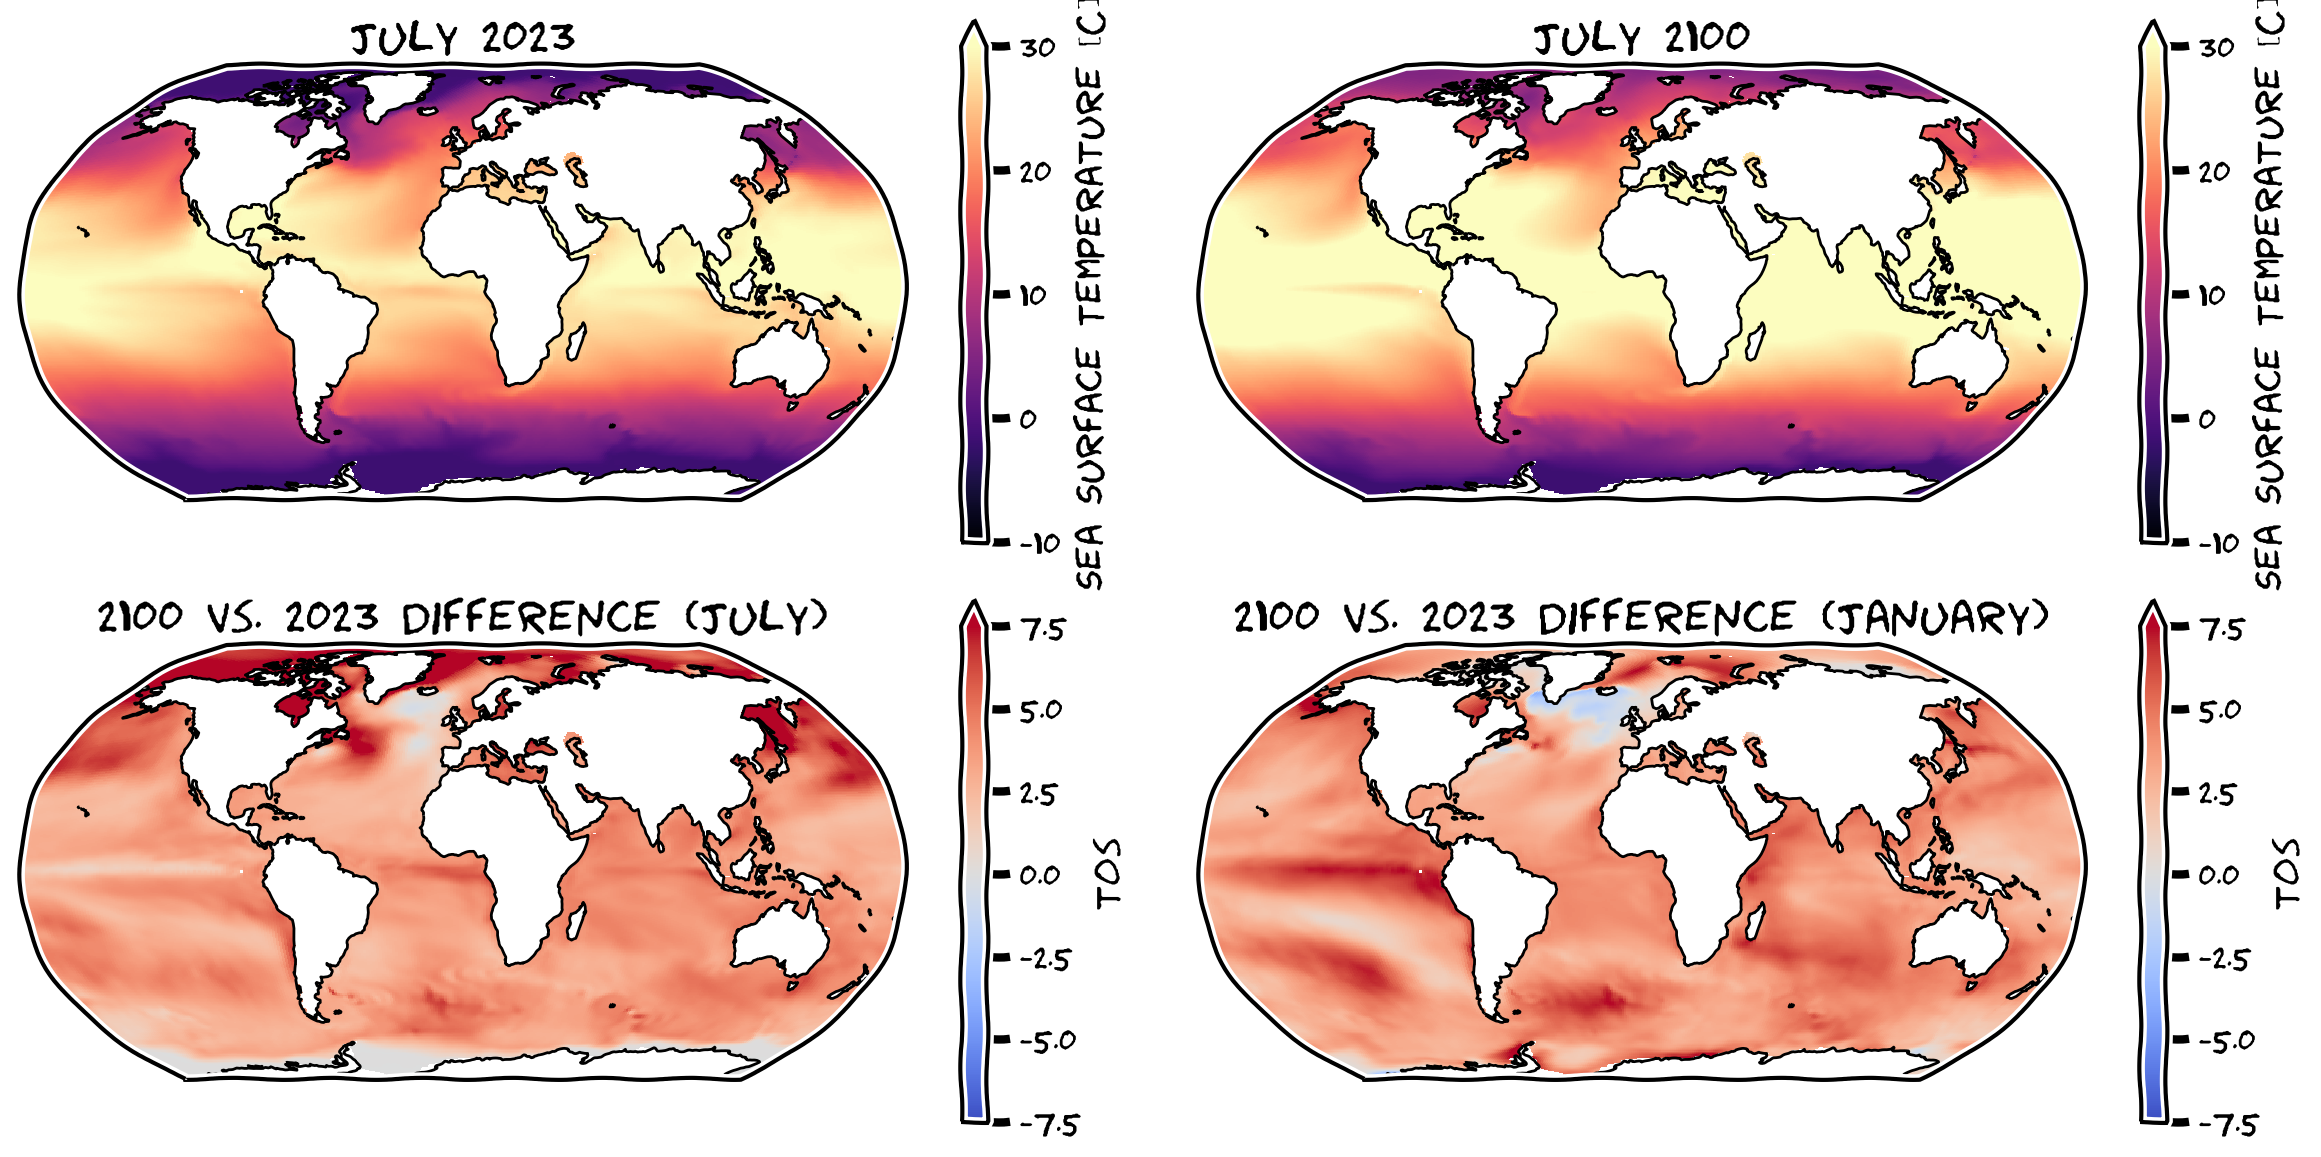

In [11]:
# to_remove solution
%matplotlib inline

# select just a single model and experiment
sst_ssp585 = dt['TaiESM1']['ssp585'].ds.tos

with plt.xkcd():
  fig, ([ax_present, ax_future], [ax_diff_july, ax_diff_jan]) = plt.subplots(
      ncols=2, nrows=2,
      figsize=[12,6],
      subplot_kw={'projection':ccrs.Robinson()}
  )

  # plot a timestep for 2023
  sst_present = sst_ssp585.sel(time='2023-07').squeeze()
  sst_present.plot(ax=ax_present, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
  ax_present.coastlines()
  ax_present.set_title('July 2023')

  # Repeat for 2100
  # Complete the following line to extract data for July 2100
  sst_future = sst_ssp585.sel(time='2100-07').squeeze()
  sst_future.plot(ax=ax_future, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
  ax_future.coastlines()
  ax_future.set_title('July 2100')

  # Now find the difference between July 2100 and July 2023
  # Complete the following line to extract the July difference
  sst_difference_july = sst_future - sst_present
  sst_difference_july.plot(ax=ax_diff_july, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-7.5, vmax=7.5, cmap='coolwarm')
  ax_diff_july.coastlines()
  ax_diff_july.set_title('2100 vs. 2023 Difference (July)')

  # Finally, find the difference between January of the two years used above
  # Complete the following line to extract the January difference
  sst_difference_jan = sst_ssp585.sel(time='2100-01').squeeze() - sst_ssp585.sel(time='2023-01').squeeze()
  sst_difference_jan.plot(ax=ax_diff_jan, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-7.5, vmax=7.5, cmap='coolwarm')
  ax_diff_jan.coastlines()
  ax_diff_jan.set_title('2100 vs. 2023 Difference (January)')

  plt.show()

## Post-figure questions

1.   What do you think is interesting about these maps of change?
2.   In what ways are the July and January maps similar or dissimilar, and can you think of any physical explanations for these (dis)similarities?
3. Why do you think the color bar axes vary? (i.e., the top panels say "*Sea Surface Temperature [$^oC$]*" while the bottom panels say "*tos*")

Many of the changes seen in the maps are a result of a changing climate under this high-emissions scenarios. But, keep in mind that these are differences between two months that are almost 80 years apart, so some of the changes are due to weather/synoptic differences between these particular months.



##**Section 1.2 Horizontal regridding**

Many CMIP6 models use distinct spatial grids, we call this the model's *native grid*. If you want to compare spatial maps from different models/observations, e.g. plot a map averaged over several models or the bias of this map relative to observations, you must first ensure the data from all the models (and observations) is on the same spatial grid. This is where regridding becomes essential!

> Regridding is applied lazily, but it is still taking time to compute *when* it is applied. So if you want to compare for example the mean over time of several models it is often much quicker to compute the mean in time over the native grid and then regrid the result of that, instead of regridding each timestep and then calculating the mean!

In [ ]:
# define a 'target' grid. This is simply a regular lon/lat grid that we will interpolate our data on
ds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1.0), {"units": "degrees_north"}),
        "lon": (["lon"], np.arange(0, 360, 1.0), {"units": "degrees_east"}),
    }
) # you can try to modify the parameters above to e.g. just regrid onto a region or make the resolution coarser etc
ds_target

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    *empty*

In [ ]:
# define the regridder object (from our source dataarray to the target)
regridder = xe.Regridder(sst_ssp585, ds_target, 'bilinear', periodic=True) # this takes some time to calculate a weight matrix for the regridding
regridder

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_384x320_180x360_peri.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (180, 360) 
Periodic in longitude?      True

In [ ]:
# now we can apply the regridder to our data
sst_ssp585_regridded = regridder(sst_ssp585) # this is a lazy operation! 
  # So it does not slow us down significantly to apply it to the full data!
  # we can work with this array just like before and the regridding will only be
  # applied to the parts that we later load into memory or plot. 
sst_ssp585_regridded

<xarray.DataArray (member_id: 1, dcpp_init_year: 1, time: 1032, lat: 180,
                   lon: 360)>
dask.array<_regrid, shape=(1, 1, 1032, 180, 360), dtype=float32, chunksize=(1, 1, 87, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 2015-01-17 00:29:59.999993 ... 2100-12-16 1...
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
  * lat             (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lon             (lon) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
Attributes:
    regrid_method:  bilinear

In [ ]:
# compare the shape to the original array
sst_ssp585

<xarray.DataArray 'tos' (member_id: 1, dcpp_init_year: 1, time: 1032, y: 384,
                         x: 320)>
dask.array<broadcast_to, shape=(1, 1, 1032, 384, 320), dtype=float32, chunksize=(1, 1, 87, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time            (time) object 2015-01-17 00:29:59.999993 ... 2100-12-16 1...
  * y               (y) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Temperature of upper boundary of the liquid ocean, includ...
    history:        2021-04-16T01:30:38Z altered by CMOR: replaced missing va...
    long_name:      Sea Surface Temperature
    original_name:  TEMP
    standard_name:  sea_surface_temperature
    units:          °C

###Mapping projected changes in SST**

Lets use the code from above to plot a map of the model data on its original (*native*) grid, and a map of the model data after it is regridded.

Text(0.5, 1.0, 'July 2100 Regridded')

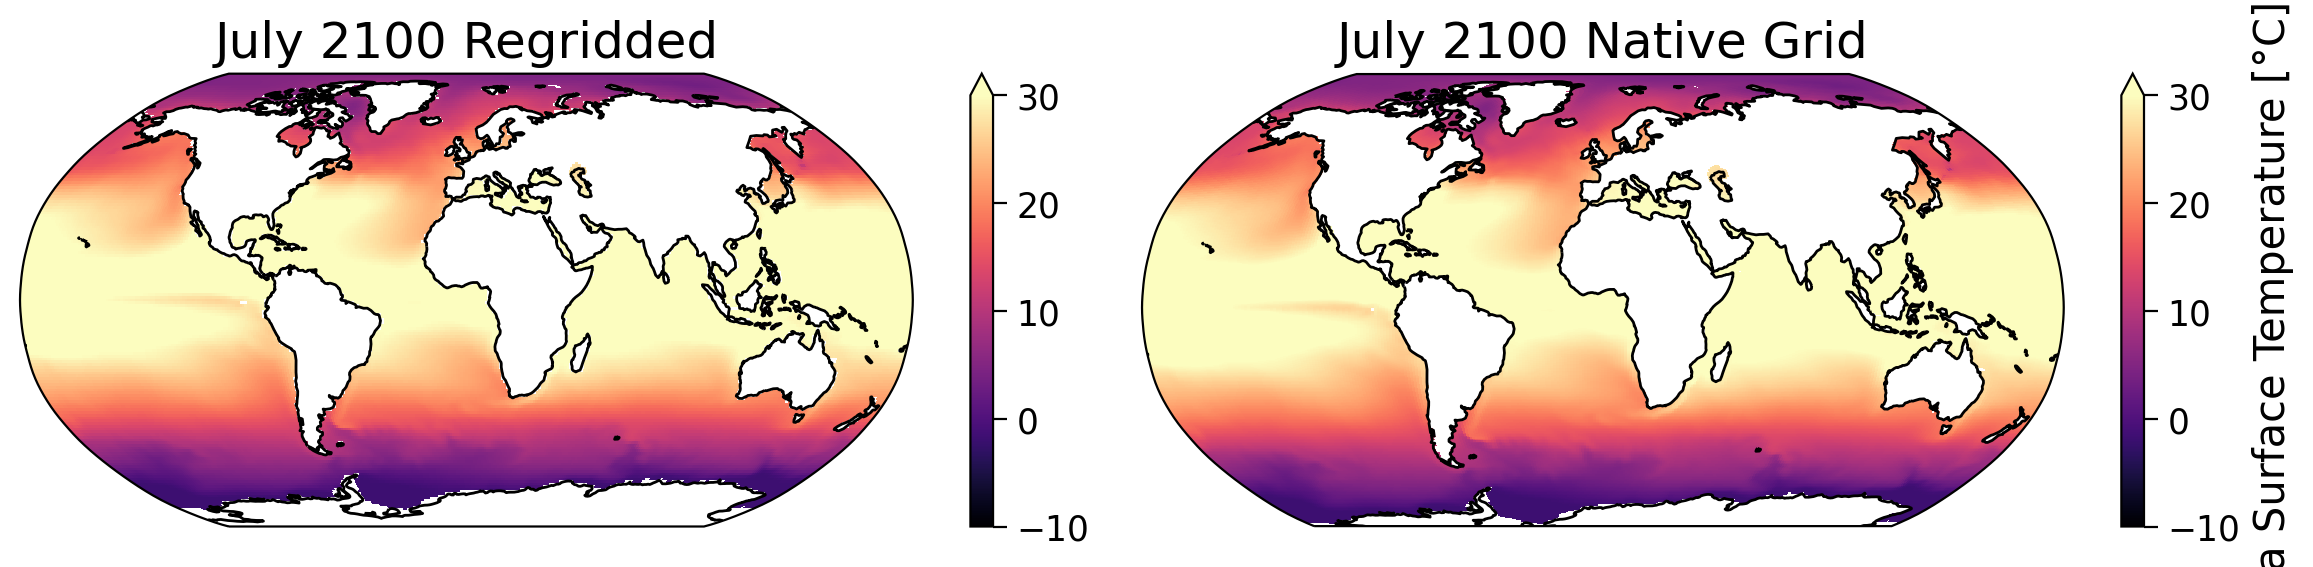

In [ ]:

fig, ([ax_regridded, ax_native]) = plt.subplots(
    ncols=2,
    figsize=[12,3],
    subplot_kw={'projection':ccrs.Robinson()}
)

# Native grid data
sst_future = sst_ssp585.sel(time='2100-07').squeeze()
sst_future.plot(ax=ax_native, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_native.coastlines()
ax_native.set_title('July 2100 Native Grid')

# Regridded data
sst_future_regridded = sst_ssp585_regridded.sel(time='2100-07').squeeze()
sst_future_regridded.plot(ax=ax_regridded, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-10, vmax=30, cmap='magma', robust=True)
ax_regridded.coastlines()
ax_regridded.set_title('July 2100 Regridded')



## Post-figure question

1. Is this what you expected to see after regridding the data?

#**Summary**

In Tutorial 1 you have: 

*   Loaded and manipulated data from various CMIP6 models and experiments
*   Created maps of future projected changes in the Earth system using CMIP6 data
*   Converted/regridded CMIP6 model data onto a desired grid. This is a critical processing step that allows us to directly compare data from different models and/or observations 
